# Imports

***

- Numerical Computations : numpy
- Dataframe manipulations : pandas
- Data Visualization : matplotlib, seaborn

- Audio Signal Manipulation - pydub
- Feature manipulation - librosa


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torchaudio
from torchaudio import transforms

# Preprocessing

***

### Extracting metadata from the dataset

Metadata file located in `~/Dataset/meta/esc50.csv` contains the following information:
- Filename
- Fold: index of the cross-validation fold
- Target: class in numerical format [0,49]
- Category

In [2]:
# read in metadata from ~/Dataset/ESC-50-master/meta/esc50.csv into a pandas dataframe
df = pd.read_csv('../Dataset/ESC-50-master/meta/esc50.csv')
print('Shape of the dataframe: ', df.shape)
print('Columns in the dataframe: ', df.columns.values)
df.sample(10)

Shape of the dataframe:  (2000, 7)
Columns in the dataframe:  ['filename' 'fold' 'target' 'category' 'esc10' 'src_file' 'take']


,filename,fold,target,category,esc10,src_file,take
1170,3-68630-A-40.wav,3,40,helicopter,True,68630,A
1485,4-193480-A-40.wav,4,40,helicopter,True,193480,A
107,1-21189-A-10.wav,1,10,rain,True,21189,A
1141,3-203377-A-39.wav,3,39,glass_breaking,False,203377,A
1142,3-20861-A-8.wav,3,8,sheep,False,20861,A
1134,3-197408-C-8.wav,3,8,sheep,False,197408,C
1156,3-253084-C-2.wav,3,2,pig,False,253084,C
757,2-83934-B-5.wav,2,5,cat,False,83934,B
1373,4-172736-A-36.wav,4,36,vacuum_cleaner,False,172736,A
135,1-260640-C-2.wav,1,2,pig,False,260640,C


In [3]:
# CONSTANTS

FILE_DIR = '../Dataset/ESC-50-master/audio/'
# Frame rate in the dataset is 44.1 kHz
FRAME_RATE = 44100
# Frame duration of 40ms = 1764 samples
FRAME_DURATION = 40e-6
SAMPLES_PER_FRAME = 1764
# and window duration of 20ms means overlap of 10ms = 0.00001 * 44100  = 441 samples
OVERLAP = 441



In [4]:
# Find the counts for Target in the df
df['target'].value_counts()

0     40
39    40
29    40
10    40
7     40
26    40
6     40
44    40
23    40
20    40
49    40
24    40
28    40
14    40
18    40
2     40
35    40
38    40
21    40
1     40
11    40
42    40
5     40
33    40
40    40
12    40
43    40
27    40
36    40
19    40
30    40
34    40
9     40
22    40
48    40
41    40
47    40
31    40
17    40
45    40
8     40
15    40
46    40
37    40
32    40
16    40
25    40
4     40
3     40
13    40
Name: target, dtype: int64

In [27]:
class AudioUtil():
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file, format='wav')
        return (sig,sr)
    
    # ----------------------------
    # Standardizing sample rate to 44100Hz
    # ----------------------------
    def resample(audio, srate):
        sig, sr = audio
        if (sr == srate):
            return audio
        no_channels = sig.shape[0]

        #Resample 1st channel:
        resig = torchaudio.transforms.Resample(sr, srate)(sig[:1,:])
        if (no_channels > 1):
            #Resample 2nd channel and merge both
            retwo = torchaudio.transforms.Resample(sr, srate)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, srate))


    # ----------------------------
    # Some audios are mono, some are stereo. We need everything to have the same dimensions.
    # Thus, we can either only select the first channel of stereo or duplicate the first channel of mono
    # ----------------------------
    @staticmethod
    def rechannel(audio, channel):
        sig, sr = audio
        if (sig.shape[0]==channel):
            return audio
        if (channel==1):
            resig = sig[:1,:]
        else:
            resig = torch.cat([sig,sig])

        return ((resig, sr))

    

    # ----------------------------
    # Standardize the length of the audio - that is, either pad or truncate the audio
    # ----------------------------
    @staticmethod
    def resize_aud(audio, ms):
        sig, sr = audio
        no_rows, sig_len = sig.shape
        max_len = sr // 1000 * ms

        #Truncate
        if (sig_len > max_len):
            sig = sig[:, :max_len]
        #Padding
        elif (sig_len < max_len):
            #Length of the paddings at the start and end of the signal
            len_start = random.randint(0, max_len-sig_len)
            len_end = max_len - len_start - sig_len

            pad_start = torch.zeros((no_rows, len_start))
            pad_end = torch.zeros((no_rows, len_end))

            sig = torch.cat((pad_start, sig, pad_end), 1)

        return (sig, sr)


    # ----------------------------
    # Refer to textbox_1 for the reasoning of this method
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # ----------------------------
    # Generating Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(audio, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = audio
        top_db = 80 #if we have more time, we can try 80
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        #shape of spec is [channel (mono or stereo etc), n_mels, time]
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)


    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec
    

                

shape of cleaned audio torch.Size([1, 220000])
sample rate 44100


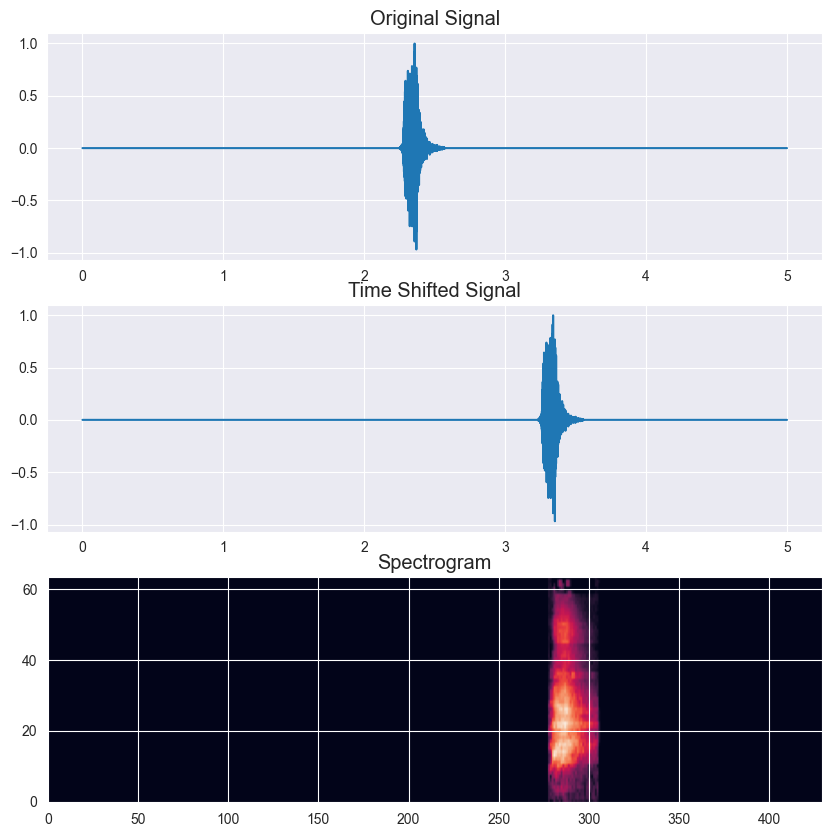

In [35]:
# Dog barking sound file 
dog_file = '1-100032-A-0.wav'
DATA_PATH = '../Dataset/ESC-50-master/audio/'

audio = AudioUtil.open(DATA_PATH + dog_file)
rechannel = AudioUtil.rechannel(audio, 1)
resamp = AudioUtil.resample(rechannel, 44100)
padded = AudioUtil.resize_aud(resamp, 5000)

print("shape of cleaned audio", padded[0].shape)
print("sample rate", padded[1])

# plot 3 subplots vertically 
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
# change font size of subtitles
plt.rcParams.update({'font.size': 12})

axs[0].plot(np.linspace(0, 5, padded[0].shape[1]), padded[0].t().numpy())
# add subtitle
axs[0].set_title('Original Signal')

shifted = AudioUtil.time_shift(padded, 0.4)
axs[1].plot(np.linspace(0, 5, shifted[0].shape[1]), shifted[0].t().numpy())
# add subtitle
axs[1].set_title('Time Shifted Signal')

sgram = AudioUtil.spectro_gram(shifted, n_mels=64, n_fft=1024, hop_len=None)
axs[2].imshow(sgram[0,:,:].detach().numpy(), aspect='auto', origin='lower')
# add subtitle 
axs[2].set_title('Spectrogram')

plt.savefig('../assets/audiotransform.png')